In [66]:
import numpy as np
import cv2
import os
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import image as Img
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

In [3]:
def plotImage(img, edges = None):
    # plot the image with edges or merely image
    if not edges:
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.gray()
        plt.imshow(img)
    else:
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.gray()
        plt.imshow(img)
        plt.plot()
        l = mlines.Line2D([xmin,xmax], [ymin,ymax])

In [4]:
def plotProfile(profile):
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(range(len(profile)), profile)

In [5]:
def fitProfileAndPlot(profile):
    # define a function to be fitted
    def func(x, a, b):
        return x*a + b 
    
    plotProfile(profile)
    
    # plot the fitted function on the profile
    popt, pcov = curve_fit(func, range(len(profile)), profile)
    popt
    plt.plot(range(len(profile)), func(range(len(profile)), *popt), \
             'g--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

In [6]:
def imgFiltering(img):
    median = cv2.medianBlur(img, 3)
    return median

In [7]:
def smooth(x, window_len=11, window='hanning'):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [8]:
def removeCloseGrad(gradients):
    # after thresholding the gradient of the profile, same large edge may create some consecutive large gradients
    nonConsecutiveEdges = [gradients[0]]
    counter = 1
    for gradient in gradients:
        if gradient - nonConsecutiveEdges[-1] == 0:
            pass
        elif gradient - nonConsecutiveEdges[-1] == counter:
            counter += 1
        else:
            nonConsecutiveEdges.append(gradient)
            counter = 1
    # the first one is fake edge created by color filling
    return nonConsecutiveEdges[1:]

In [9]:
def filterAccordingToWidth(gradients):
    # WARNING!!
    # this is a cheating trick, manually measured the tow width -> around 140 pxls
    towWidth = 140
    tows = [gradients[0]]
    for gradient in gradients:
        if (gradient - tows[0])%towWidth < 20 or (gradient - tows[0])%towWidth > 120:
            tows.append(gradient)
    return tows[1:]

In [11]:
# find consecutive zeros
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [44]:
# processing steps from Profactor, first interpolate the black dots
def filterRow(row):
    zeroRanges = zero_runs(row)
    if zeroRanges.size != 0:
        for zeroRange in zeroRanges:
            if zeroRange[0] == 0 and zeroRange[1] != len(row):
                row[zeroRange[0] : zeroRange[1]].fill(row[zeroRange[1]])
            elif zeroRange[0] != 0 and zeroRange[1] == len(row):
                row[zeroRange[0] : zeroRange[1]].fill(row[zeroRange[0]-1])
            elif zeroRange[0] != 0 and zeroRange[1] != len(row):
                x = [zeroRange[0] - 1, zeroRange[1]]
                y = [row[zeroRange[0] - 1], row[zeroRange[1]]]
                row[zeroRange[0] : zeroRange[1]] = np.interp(range(zeroRange[0], zeroRange[1]), x, y)
    else:
        return row
    return row

In [48]:
def printStatus(fileName, img):
    print('The file name is', fileName, \
             '\nThe image size', img.shape, \
             '\nThe whole image mean value:', np.mean(img), \
             '\nThe maximum value:', np.amax(img), \
             '\nThe minimum value:', np.amin(img), \
             '\n\nThe image left part, mean value:', np.mean(img[:, :1000]), \
             '\nThe image left part, max value:', np.amax(img[:, :1000]), \
             '\nThe image left part, min value:', np.amin(img[:, :1000]), \
             '\n\nThe image right part, mean value:', np.mean(img[:, 1000:]), \
             '\nThe image right part, max value:', np.amax(img[:, 1000:]), \
             '\nThe image right part, min value:', np.amin(img[:, 1000:]), \
             '\n-------------------------------------------------------\n')

In [63]:
def saveImg(fileName, img):
    fileName = fileName[:-4]
    im = Image.fromarray(img)
    im.save(fileName+'-normalized.png')

The file name is buffer_2020-04-22-122920.603205805.json_range.png 
The image size (512, 3360) 
The whole image mean value: 21235.300877743677 
The maximum value: 32019 
The minimum value: 0 

The image left part, mean value: 14992.5129453125 
The image left part, max value: 19966 
The image left part, min value: 0 

The image right part, mean value: 23880.550001655192 
The image right part, max value: 32019 
The image right part, min value: 0 
-------------------------------------------------------

After rows are filtered
The file name is buffer_2020-04-22-122920.603205805.json_range.png 
The image size (512, 3360) 
The whole image mean value: 21314.267382231214 
The maximum value: 34160 
The minimum value: 5729 

The image left part, mean value: 15050.152279296875 
The image left part, max value: 21162 
The image left part, min value: 5729 

The image right part, mean value: 23968.55344279661 
The image right part, max value: 34160 
The image right part, min value: 15500 
----------

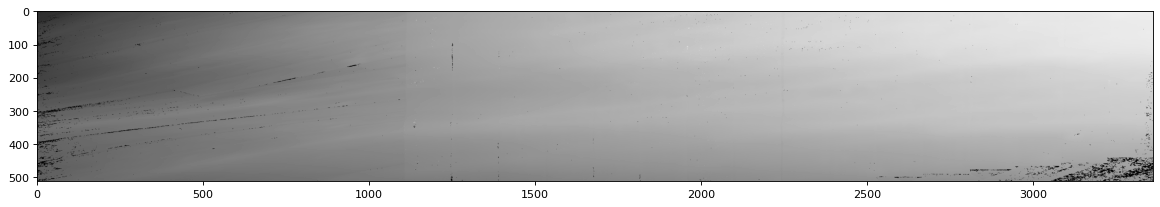

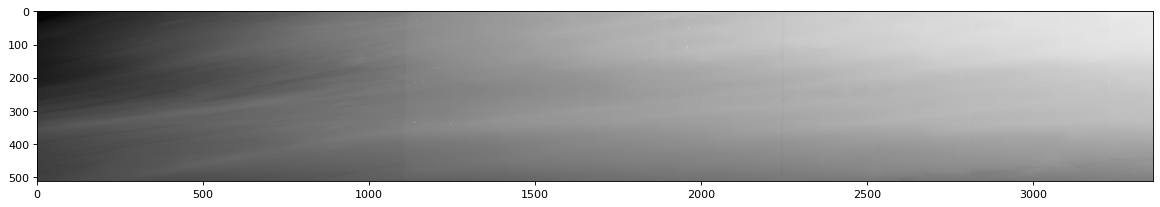

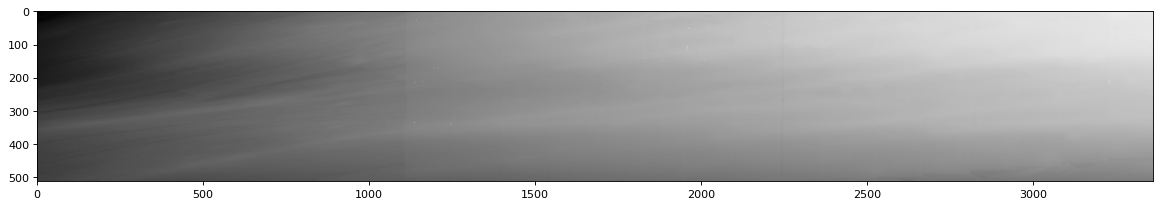

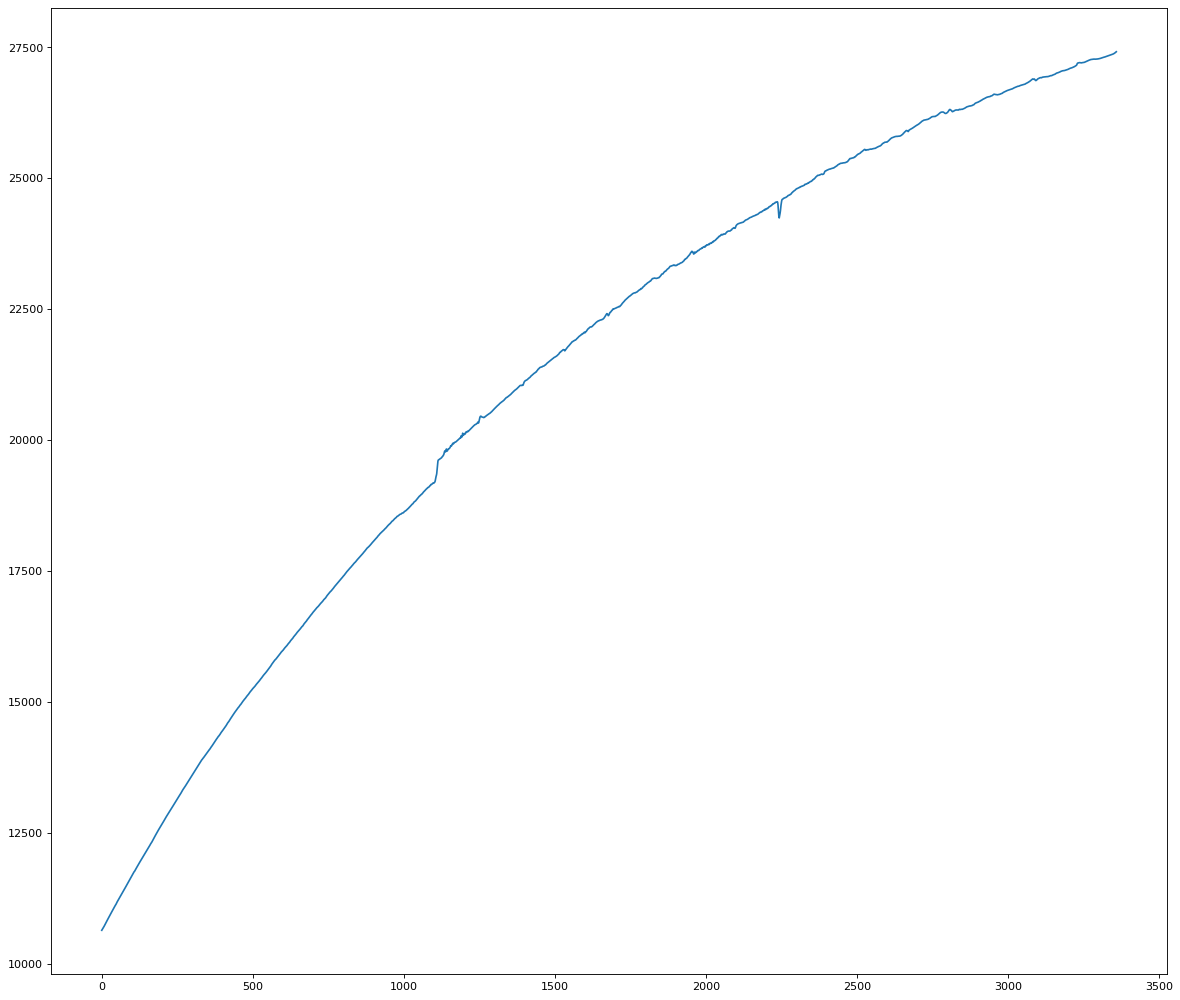

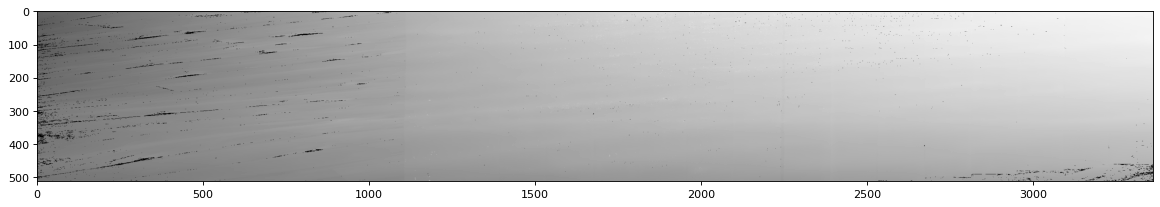

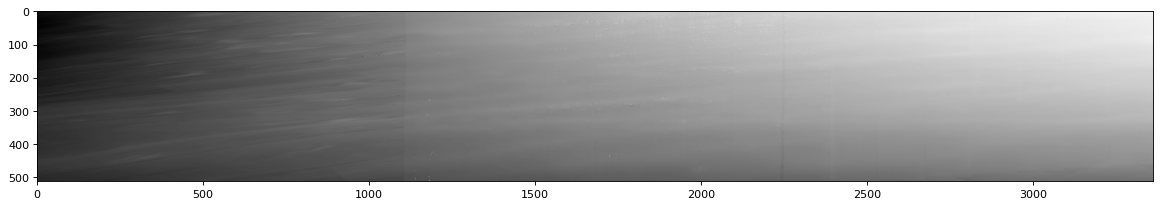

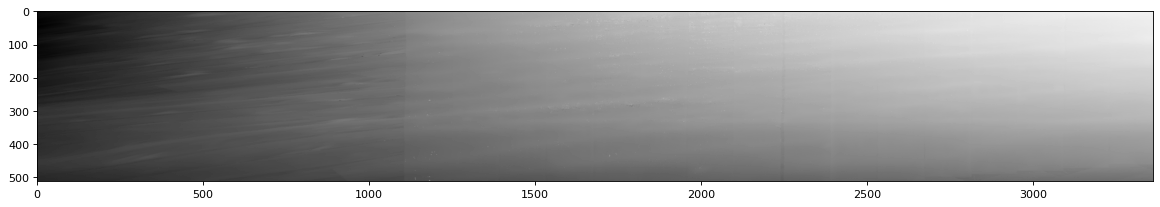

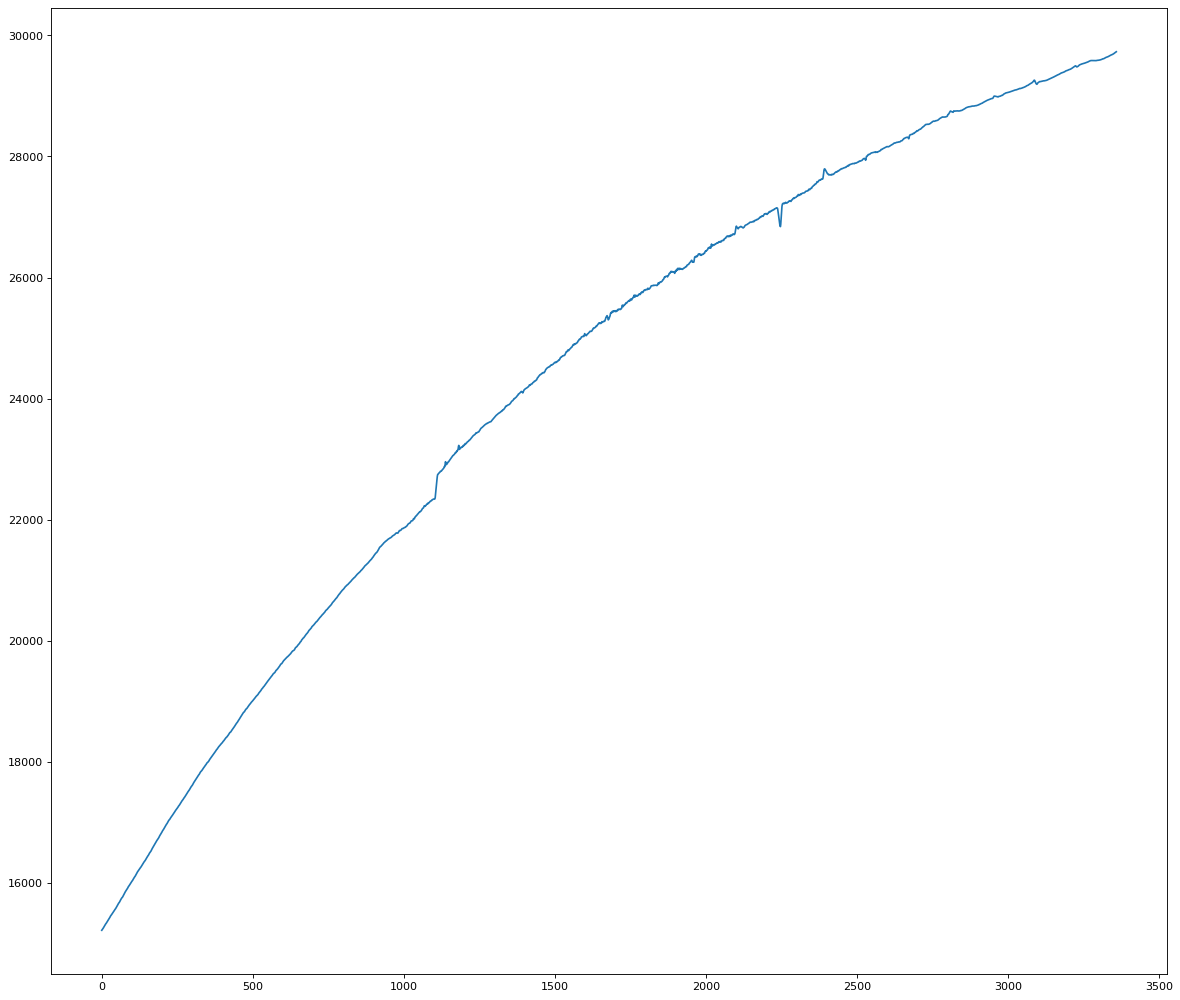

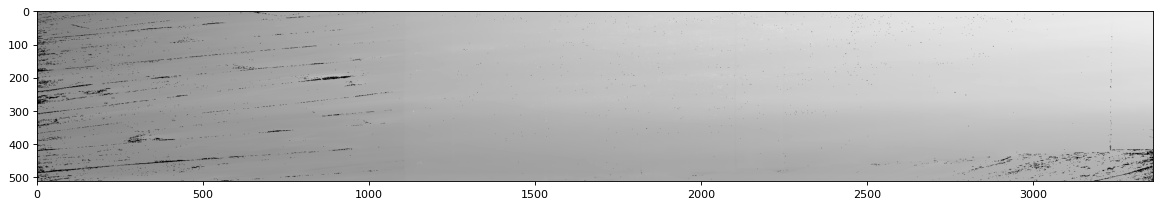

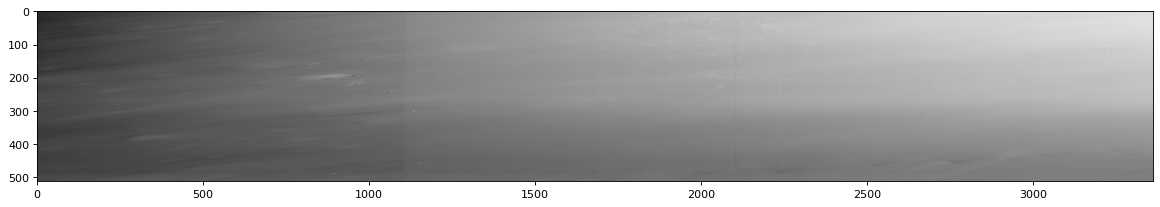

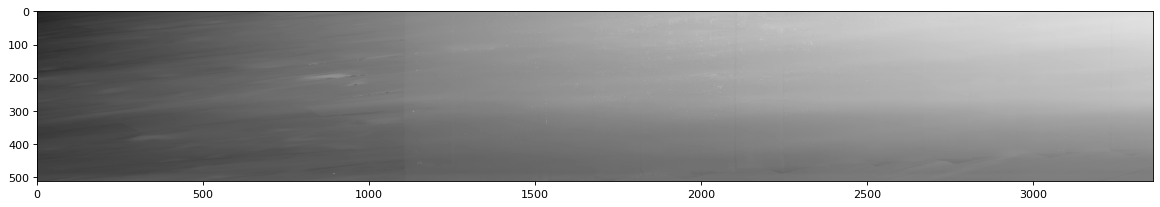

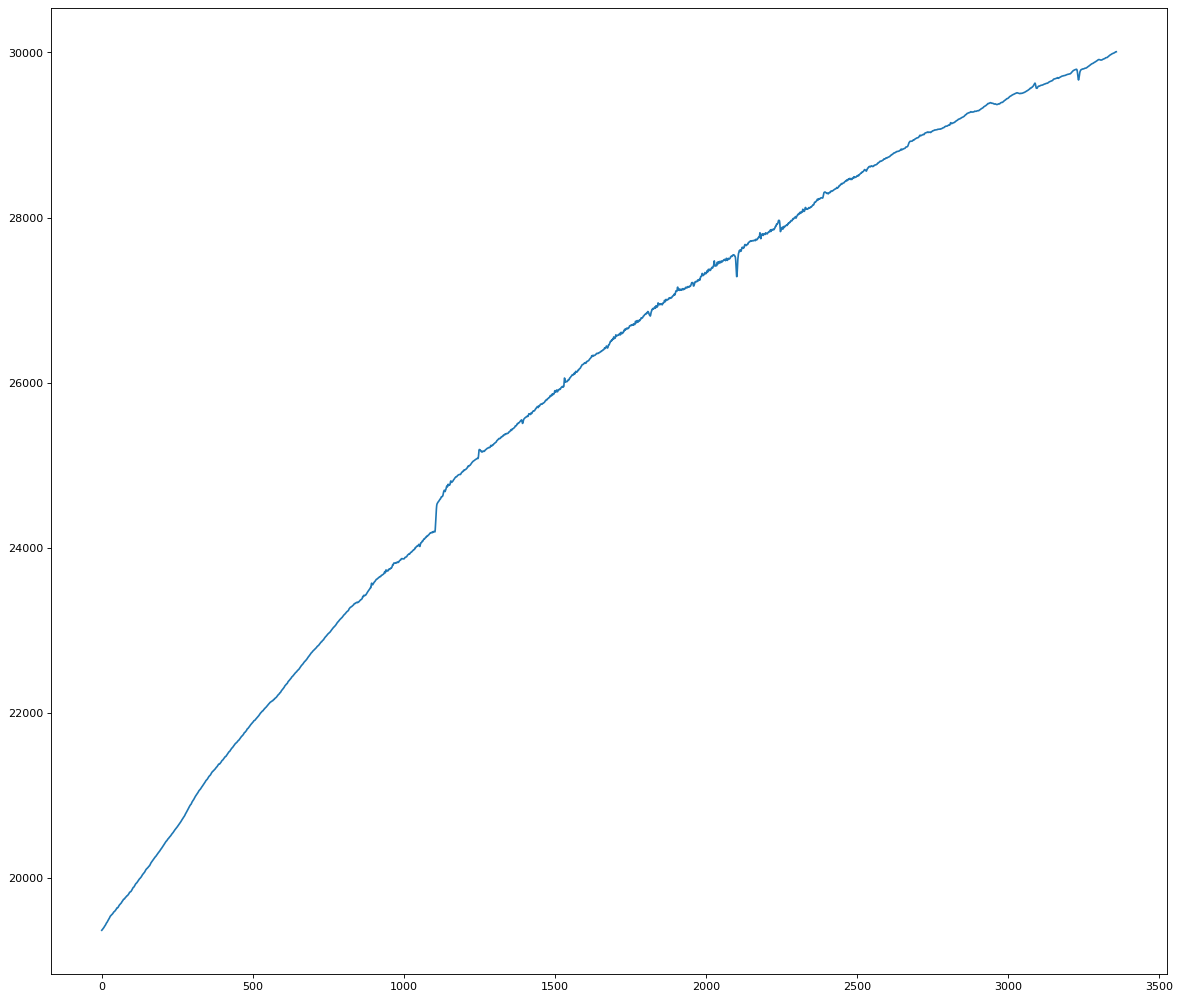

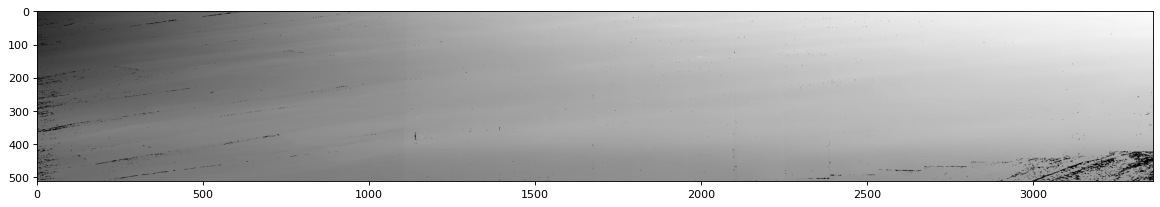

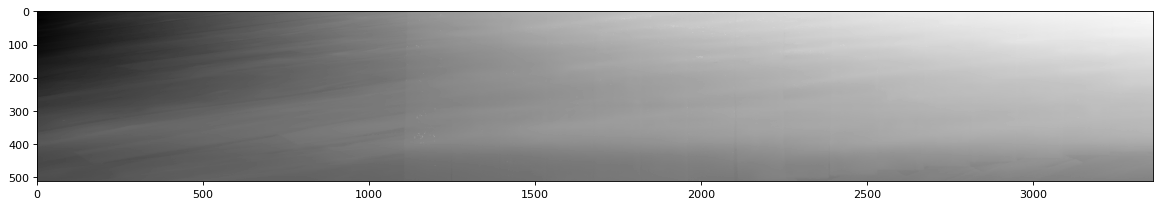

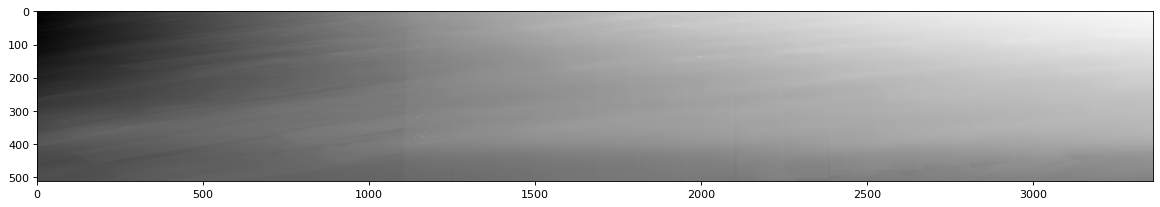

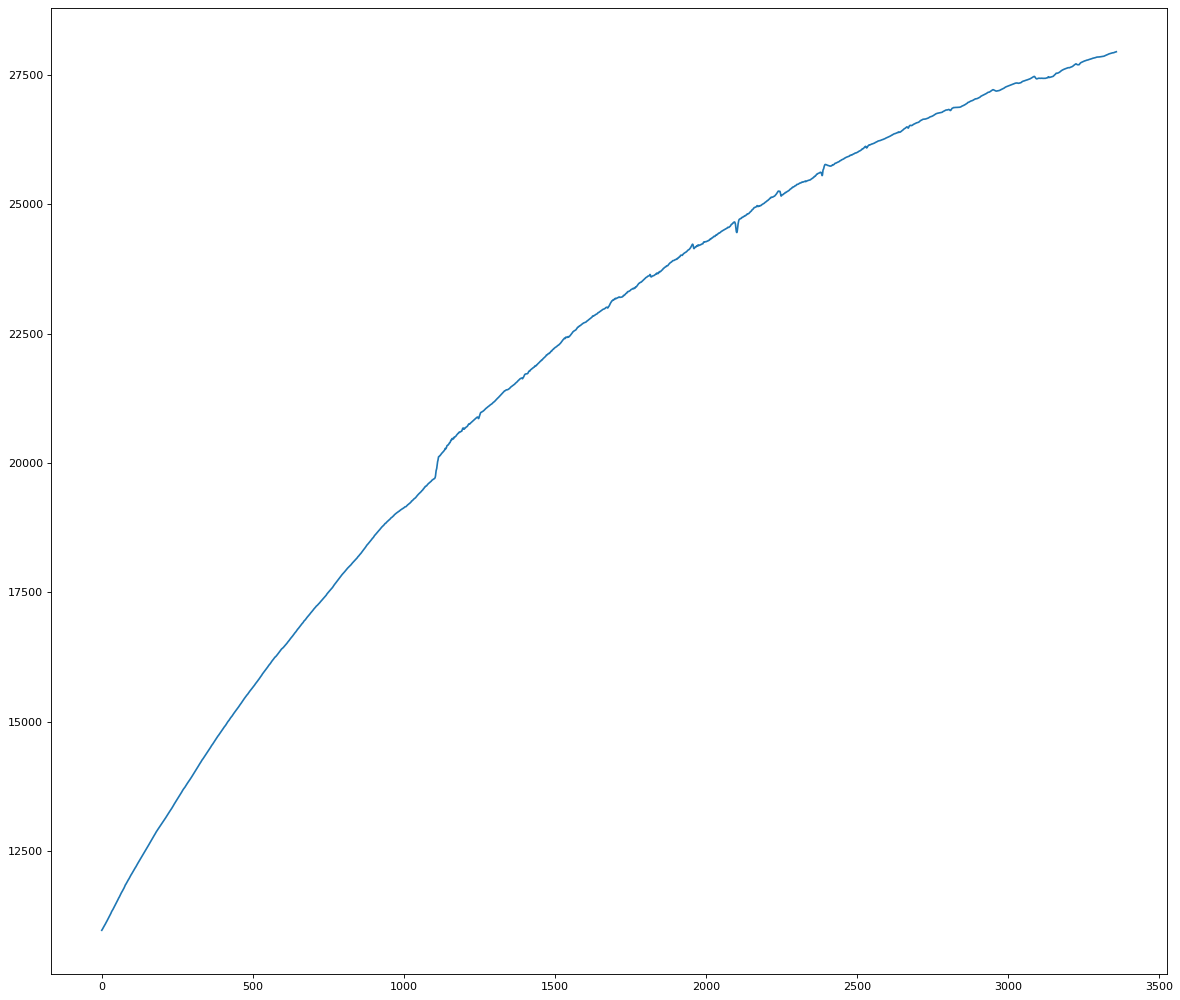

In [68]:
# sourceFolder = '/Users/zeekile/Desktop/Infy/source/20200422_afternoon_range_unconverted/'
sourceFolder = '/Users/zeekile/Desktop/Infy/nlr_data/goodRange/'
counter = 0
for fileName in os.listdir(sourceFolder): 
    if fileName.endswith(".png"):
        filePath = os.path.join(sourceFolder, fileName)
        img = cv2.imread(filePath, -1)
        imgOriginalCopy = np.copy(img)
        imgFilled = np.copy(img)
        img = imgFiltering(img)
        printStatus(fileName, img)
        
        plotImage(imgOriginalCopy)
        for rowId in range(len(imgFilled)):
            imgFilled[rowId] = filterRow(imgFilled[rowId])
        plotImage(imgFilled)
        print('After rows are filtered')
        printStatus(fileName, imgFilled)
        
        # normalize the image
        normalizedImg = imgFilled - np.amin(imgFilled)
        normalizedImg = np.multiply((255.0/normalizedImg.max()), normalizedImg)
        normalizedImg = normalizedImg.astype(int)
        Img.imsave('name.png', normalizedImg)
        plotImage(normalizedImg)
        
        printStatus(fileName, normalizedImg)

        # create a mean vertically
        means = np.mean(imgFilled, axis=0)
        smoothed = savgol_filter(means, 7, 5)
        plotProfile(smoothed)

        # gradientArr = np.gradient(smoothed)
        # largeGradIndex = removeCloseGrad((np.nonzero(gradientArr>50))[0])
        # towXs = filterAccordingToWidth(largeGradIndex)
        # print(towXs)
        # plotProfile(gradientArr)
        # plotProfile(np.diff(smoothed, n=3))
        # plt.show()
        
        # 
#     break